# Features Alberto

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import time
import logging
import missingno
import sys

### Parameters

In [3]:
n_assets = 4
N = 50  # combinations
rnd_seed = 42
date_start = '2020-01-30'

# Select metric for evaluation 1\2\3 (r2\mse\mae)
metric_choice = '1' # Must be in ' '

### Functions

In [4]:
def plot_feature_importance(model, feature_names, model_name):
    
    #Plots and prints the top 10 most important features.
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
# Rolling Sharpe Ratio calculation
def rolling_sharpe_ratio(returns, window=30, risk_free_rate=0.00007858): # Daily risk-free considering 0.02% annual rate

    excess_returns = returns - risk_free_rate
    rolling_mean = pd.Series(excess_returns).rolling(window).mean()
    rolling_std = pd.Series(excess_returns).rolling(window).std()
    sharpe_ratio = rolling_mean / rolling_std

    # Replace infinities with 0
    sharpe_ratio.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Ensure no NaN values
    sharpe_ratio.fillna(0, inplace=True)

    return sharpe_ratio

In [6]:
# Cross validation function

def time_grouped_cv(model, X, y):
    
    
    
    kf = KFold(n_splits=5, shuffle=False)
    scores = []
    
    combined_matrix_filtered = combined_matrix.loc[X.index].copy()
    combined_matrix_filtered['time_step'] = combined_matrix_filtered['time_step'].reset_index(drop=True)
    
    print("\nStarting Time-Grouped Cross-Validation...")
    for fold, (train_idx, test_idx) in enumerate(kf.split(np.unique(combined_matrix_filtered['time_step'])), start=1):
        '''
        log_and_print(f"Processing Fold {fold}/5...")'
        '''
        time.sleep(0.2)  # Just to make it more readable if running fast
        
        train_steps = combined_matrix_filtered['time_step'].iloc[train_idx].values
        test_steps = combined_matrix_filtered['time_step'].iloc[test_idx].values
        
        train_mask = combined_matrix_filtered['time_step'].isin(train_steps).values
        test_mask = combined_matrix_filtered['time_step'].isin(test_steps).values       
        
        X_train, X_test = X.loc[train_mask], X.loc[test_mask]
        y_train, y_test = y.loc[train_mask], y.loc[test_mask]        
                
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Calculate selected metric
        score = selected_metric_func(y_test, y_pred)
        scores.append(score)

        
    mean_score = np.mean(scores)

    return mean_score


In [7]:
# Based on the chosen metric the function evaluates the model
def evaluate_model(name, model, X_test, y_test, metric):
    y_pred = model.predict(X_test)
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    

    # Calculate Directional Accuracy
    y_pred_dir = np.sign(y_pred)
    y_test_dir = np.sign(y_test)
    directional_accuracy = np.mean(y_pred_dir == y_test_dir)


    # Return selected metric score
    if metric == "R²":
        return r2
    elif metric == "MAE":
        return mae
    elif metric == "DA":
        return directional_accuracy
    else:
        raise ValueError(f"Invalid metric selected: {metric}")


In [8]:
def plot_feature_importances(model, feature_names, model_name):
    
    """Plots and prints the top 10 most important features."""
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()
    
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)


In [9]:
def custom_random_search(model, param_grid, X, y, n_iter=10):
    best_score = -np.inf
    best_params = None
    feature_columns = X.columns.tolist()  # Get the feature names directly from X
        

    
    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        model.set_params(**params)
        
        score = time_grouped_cv(model, X, y)

        
        if score > best_score:
            best_score = score
            best_params = params
    
    
    model.set_params(**best_params)    
    model.fit(X, y)
    # Feature Importance Extraction
    if hasattr(model, "feature_importances_"):
        plot_feature_importances(model, feature_columns, model.__class__.__name__)
    return model, best_score, best_params

In [10]:
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)

### Features

In [11]:
def add_engineered_features(df):
   
    
    # Inflation differential
    df["inflation_diff"] = df["INFLEUR5Y"] - df["INFLUSD5Y"]
    
    # Volatility spread
    df["VIX_V2X_spread"] = df["VIX"] - df["V2X"]
    
    # Yield spreads
    df["EUR_yield_spread"] = df["5Y EUR RATE"] - df["3M EUR RATE"]
    df["USD_yield_spread"] = df["5Y USD RATE"] - df["3M USD RATE"]
    
    # FX spread
    df["EURUSD_EURJPY_spread"] = df["EURUSD"] - df["EURJPY"]
    
    # Commodity spread
    df["GOLD_WTI_spread"] = df["GOLD"] - df["WTI"]
    
    # Differenced features
    for col in ["VIX", "V2X", "MOVE", "EURUSD", "EURJPY", "GOLD", "5Y EUR RATE", "inflation_diff"]:
        df[f"{col}_diff"] = df[col].diff()
    
    # Interaction terms
    df["VIX_MOVE_interaction"] = df["VIX_diff"] * df["MOVE_diff"]
    df["VIX_EURUSD_interaction"] = df["VIX_diff"] * df["EURUSD_diff"]
    
    # Momentum Indicators: Rolling Averages (7-day and 30-day)
    for col in df.columns:
        if col.endswith('_diff'):
            df[f'{col}_ma7'] = df[col].rolling(window=7).mean()
            df[f'{col}_ma30'] = df[col].rolling(window=30).mean()

    # Volatility Clustering: Rolling Standard Deviations
    for col in ['VIX', 'V2X', 'MOVE']:
        df[f'{col}_volatility_7d'] = df[col].rolling(window=7).std()
        df[f'{col}_volatility_30d'] = df[col].rolling(window=30).std()

    # Non-linear Effects: Squared Terms
    for col in df.columns:
        if col.endswith('_diff'):
            df[f'{col}_squared'] = df[col] ** 2

    # Signal Ratios
    df['VIX_MOVE_ratio'] = df['VIX'] / df['MOVE'].replace(0, np.nan)
    df['EURUSD_VIX_ratio'] = df['EURUSD'] / df['VIX'].replace(0, np.nan)
    df['EUR_Inflation_Rate_ratio'] = df['5Y EUR RATE'] / df['INFLUSD5Y'].replace(0, np.nan)
    df['USD_Rate_Spread_ratio'] = df['5Y USD RATE'] / df['3M USD RATE'].replace(0, np.nan)
    
    # Drop NaN rows after diff()
    df.dropna(inplace=True)
    
    return df

### Hyperparameters

In [12]:
# Define hyperparameter grids

gbr_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 20, 30],    # Added regularization
    'min_samples_leaf': [1, 2, 4]               # Added regularization
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],              # Added regularization
    'gamma': [0, 0.1, 0.2],                     # Added regularization
    'reg_alpha': [0, 0.1, 0.5],                 # L1 regularization (lasso)
    'reg_lambda': [1, 1.5, 2.0, 3.0]            # L2 regularization (ridge)
}

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],           # Added regularization
    'max_samples': [0.5, 0.75, 1.0]             # Added regularization
}


### Insert parameters

In [13]:
# Map choice to metric
metric_map = {
    "1": ("R²", r2_score),
    "2": ("MAE", mean_absolute_error),
    "3": ("DA", directional_accuracy)
}

# Get selected metric
if metric_choice not in metric_map:
    print()
    print("Invalid choice. Defaulting to R².")
    selected_metric_name, selected_metric_func = metric_map["1"]
else:
    selected_metric_name, selected_metric_func = metric_map[metric_choice]
print()
print(f"Selected metric: {selected_metric_name}")



Selected metric: R²


### Load data

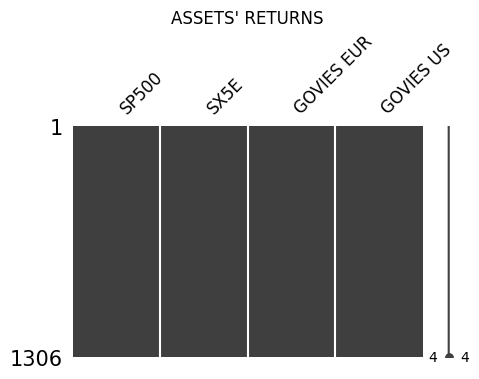

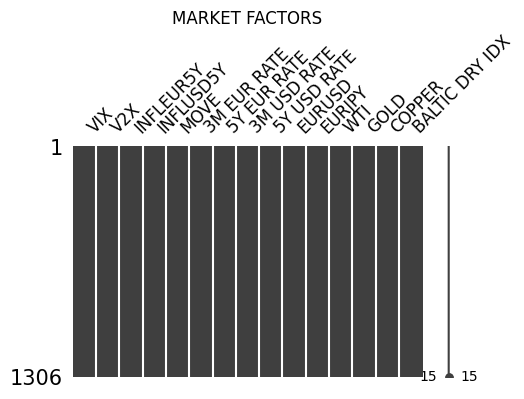

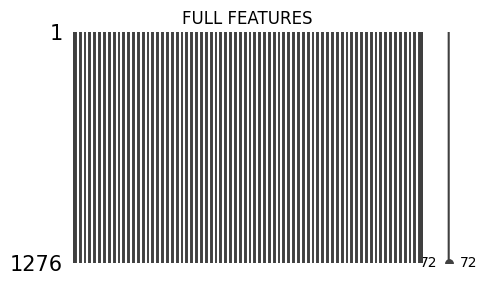

In [14]:
# Load real data
filename = 'IP25_DATA_day1/CPO_DATA.xlsx'
data = pd.read_excel(filename, header=3, sheet_name='RAW_DATA')
data.set_index('date', inplace=True)
data = data[date_start:]

missingno.matrix(data.iloc[:,0:4],figsize=(5,3), fontsize=12)
plt.title("ASSETS' RETURNS")
plt.show()

missingno.matrix(data.iloc[:,4:],figsize=(5,3), fontsize=12)
plt.title("MARKET FACTORS")
plt.show()

data = add_engineered_features(data)

missingno.matrix(data,figsize=(5,3), fontsize=12)
plt.title("FULL FEATURES")
plt.show()

### Random weights

In [15]:
# Calculate returns for the first 4 columns (assets) and drop NaN rows
data.iloc[:, 0:n_assets] = data.iloc[:, 0:n_assets].pct_change()
data = data.dropna()

# Extract asset returns (4 assets) and features (15 features)
asset_returns = data.iloc[:, 0:n_assets]
features = data.iloc[:, n_assets:]

# Generate random weight combinations using Dirichlet distribution
np.random.seed(rnd_seed)
random_weights = np.random.dirichlet(np.ones(n_assets), size=N)

# Convert to DataFrame
portfolio_weights = pd.DataFrame(random_weights, columns=['w1', 'w2', 'w3', 'w4'])

print(portfolio_weights.head())

         w1        w2        w3        w4
0  0.082197  0.527252  0.230641  0.159911
1  0.070375  0.070363  0.024826  0.834435
2  0.161962  0.216972  0.003665  0.617401
3  0.735638  0.098290  0.082638  0.083434
4  0.179898  0.368931  0.280463  0.170708


### Combined matrix

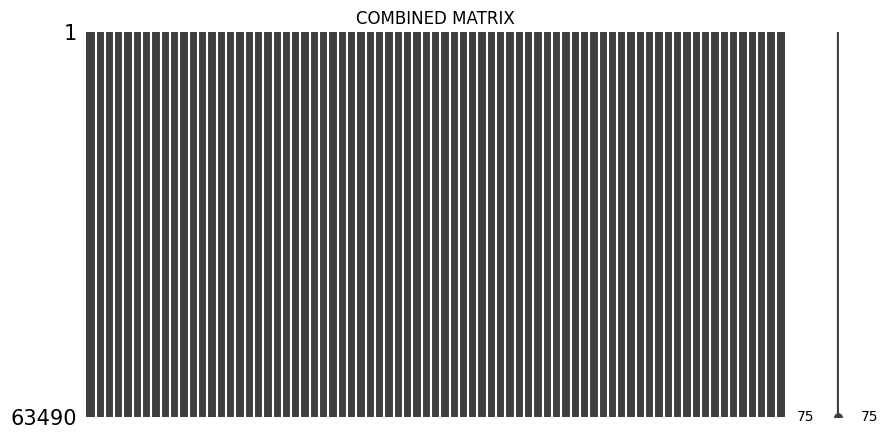

         w1        w2        w3        w4    VIX      V2X  INFLEUR5Y  \
0  0.336331  0.042661  0.460876  0.160132  57.83  74.3321      0.656   
1  0.373471  0.513327  0.086769  0.026433  57.83  74.3321      0.656   
2  0.057602  0.124041  0.379394  0.438962  57.83  74.3321      0.656   
3  0.004610  0.472398  0.357018  0.165974  57.83  74.3321      0.656   
4  0.033661  0.108594  0.754825  0.102920  57.83  74.3321      0.656   
5  0.122618  0.203524  0.075767  0.598091  57.83  74.3321      0.656   
6  0.710752  0.062816  0.148919  0.077513  57.83  74.3321      0.656   
7  0.166638  0.018682  0.467477  0.347203  57.83  74.3321      0.656   
8  0.017373  0.107365  0.785242  0.090021  57.83  74.3321      0.656   
9  0.029258  0.125659  0.793280  0.051803  57.83  74.3321      0.656   

   INFLUSD5Y   MOVE  3M EUR RATE  ...  GOLD_diff_squared  \
0      0.445  138.4       -0.428  ...            5416.96   
1      0.445  138.4       -0.428  ...            5416.96   
2      0.445  138.4       -

In [16]:
# Number of time steps (T) and portfolios (N)
T = len(features)
N = len(portfolio_weights)


### Weights-Features matrix ###
# Create the correct NxT matrix
features_repeated = features.loc[features.index.repeat(N)].reset_index(drop=True) # Repeat each row of features N times
portfolio_repeated = pd.DataFrame(   # Tile (cycle) portfolio weights T times so they align with features
    np.tile(portfolio_weights, (T, 1)),
    columns=['w1', 'w2', 'w3', 'w4'])
combined_matrix = pd.concat([portfolio_repeated, features_repeated], axis=1) # Combine features and weights side by side


### Adding PTF returns ###
# Recalculate portfolio returns using weights and asset returns
portfolio_returns = np.sum(portfolio_repeated.values * asset_returns.loc[asset_returns.index.repeat(N)].values, axis=1)
portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=['portfolio_return'])  # Convert to DataFrame for consistency
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix


### Adding Sharpe Ratios ###
combined_matrix['sharpe_ratio'] = rolling_sharpe_ratio(combined_matrix['portfolio_return'], window=30) # Calculate Sharpe ratios for all rows (NxT)
combined_matrix['sharpe_ratio'].fillna(0, inplace=True) # Handle NaNs by replacing with zero 
combined_matrix = combined_matrix[combined_matrix['sharpe_ratio'] != 0].reset_index(drop=True) # Remove rows where Sharpe ratio is NaN or zero


# Group rows by time steps
time_steps = np.arange(len(features))
combined_matrix['time_step'] = np.repeat(time_steps, N)[:len(combined_matrix)] # Assign time step groups, repeated N times (so rows for t1-tN are grouped)


### Checks ###
missingno.matrix(combined_matrix,figsize=(10,5), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

# Now the combined matrix has the following structure: weights, features, portfolio returns, sharpe ratio, time steps (0-N)
print(combined_matrix.head(10))



### Prediction Matrix

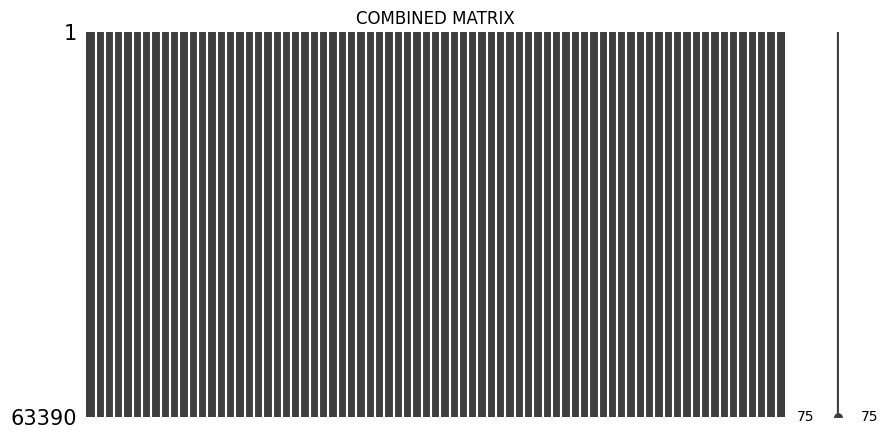

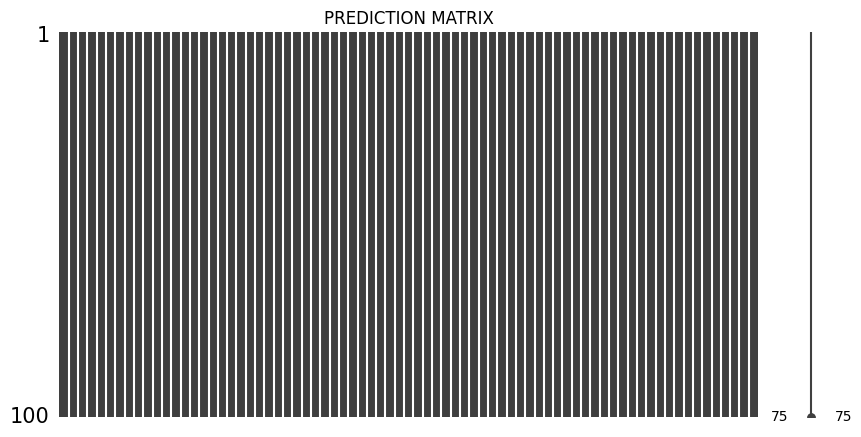

X shape: (63390, 72), y shape: (63390,)
Matching indices: True


In [17]:
# PREDICTION MATRIX
N_P = 2 # how many time step to predict from bottom
predict_matrix = combined_matrix[(-N*N_P):]
combined_matrix = combined_matrix[0:(-N*N_P)]


### Checks ###
missingno.matrix(combined_matrix,figsize=(10,5), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

missingno.matrix(predict_matrix,figsize=(10,5), fontsize=12)
plt.title("PREDICTION MATRIX")
plt.show()


# Prepare features (X) and target (y)
X = combined_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])
y = combined_matrix['sharpe_ratio']

# Ensure indices of X and y match
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Matching indices: {(X.index == y.index).all()}")

# Split data into training and testing sets
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]



### Model Training


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


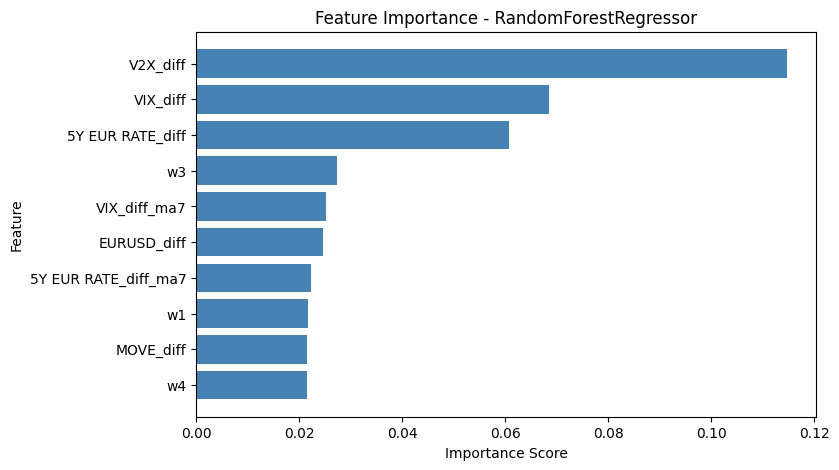


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


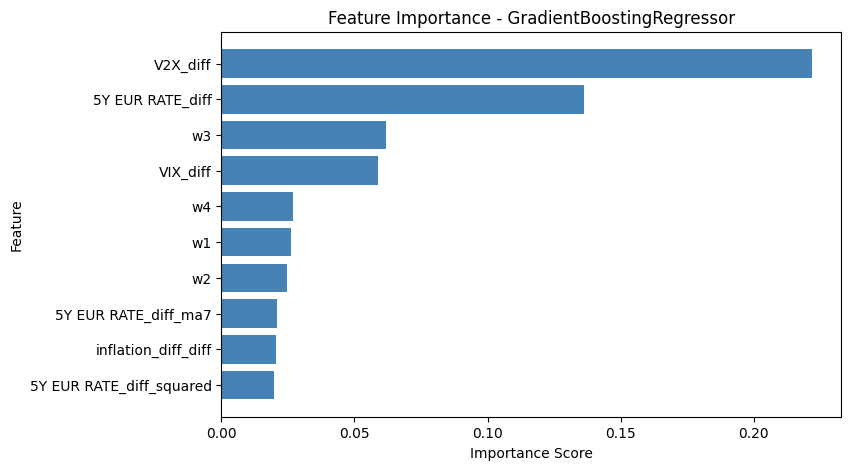


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


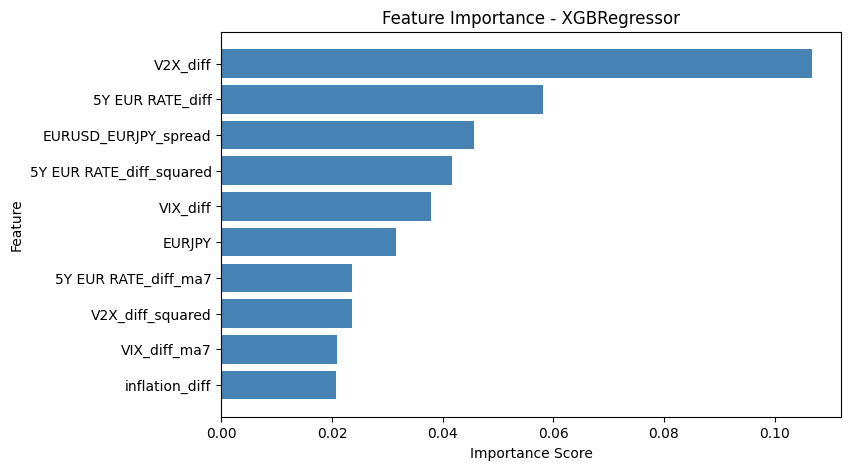


Best Random Forest hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_samples': 0.75}
Regularization params (RF): max_features=log2, max_samples=0.75

Best Gradient Boosting hyperparameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'min_samples_split': 2, 'min_samples_leaf': 1}
Regularization params (GBR): min_samples_split=2, min_samples_leaf=1

Best XGBoost hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'subsample': 1.0, 'min_child_weight': 1, 'gamma': 0.0, 'reg_alpha': 0.5, 'reg_lambda': 3.0}
Regularization params (XGB): min_child_weight=1, gamma=0.0, reg_alpha=0.5, reg_lambda=3.0


In [18]:




gbr = GradientBoostingRegressor(random_state=rnd_seed)
rf = RandomForestRegressor(random_state=rnd_seed)
xgb = XGBRegressor(random_state=rnd_seed)

# Random search with time grouping
rf_best_model, rf_best_score, rf_best_params = custom_random_search(rf, rf_params, X_train, y_train)
gbr_best_model, gbr_best_score, gbr_best_params = custom_random_search(gbr, gbr_params, X_train, y_train)
xgb_best_model, xgb_best_score, xgb_best_params = custom_random_search(xgb, xgb_params, X_train, y_train)


print("\nBest Random Forest hyperparameters:", rf_best_params)
print("Regularization params (RF): max_features={}, max_samples={}".format(
    rf_best_params.get('max_features'), rf_best_params.get('max_samples')))

print("\nBest Gradient Boosting hyperparameters:", gbr_best_params)
print("Regularization params (GBR): min_samples_split={}, min_samples_leaf={}".format(
    gbr_best_params.get('min_samples_split'), gbr_best_params.get('min_samples_leaf')))

print("\nBest XGBoost hyperparameters:", xgb_best_params)
print("Regularization params (XGB): min_child_weight={}, gamma={}, reg_alpha={}, reg_lambda={}".format(
    xgb_best_params.get('min_child_weight'), 
    xgb_best_params.get('gamma'),
    xgb_best_params.get('reg_alpha'),
    xgb_best_params.get('reg_lambda')))

_ = evaluate_model("Random Forest", rf_best_model, X_test, y_test,"MAE")
_ = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,"MAE")
_ = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,"MAE")


# prediction
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb

W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()].iloc[:,0:4]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()].iloc[:,0:4]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()].iloc[:,0:4]
